In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder

In [2]:
# Load the dataset
file_path = 'Total_Crops.csv'
data = pd.read_csv(file_path)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85260 entries, 0 to 85259
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   mandiid          85260 non-null  int64 
 1   cropid           85260 non-null  int64 
 2   cropname         85260 non-null  object
 3   mandiname        85260 non-null  object
 4   arrivalquantity  85260 non-null  int64 
 5   maximumprice     85260 non-null  int64 
 6   minimumprice     85260 non-null  int64 
 7   modalprice       85260 non-null  int64 
 8   date             85260 non-null  object
dtypes: int64(6), object(3)
memory usage: 5.9+ MB


In [3]:
# Take input from the user for mandiid and cropid
mandiid_input = int(input("Enter mandiid: "))
cropid_input = int(input("Enter cropid: "))

Enter mandiid:  778
Enter cropid:  1


In [4]:
# Filter data based on user input
filtered_data = data[(data['mandiid'] == mandiid_input) & (data['cropid'] == cropid_input)]

In [5]:
# Drop the arrivalquantity attribute
filtered_data = filtered_data.drop(columns=['arrivalquantity'])

In [6]:
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 494 entries, 2 to 85232
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   mandiid       494 non-null    int64 
 1   cropid        494 non-null    int64 
 2   cropname      494 non-null    object
 3   mandiname     494 non-null    object
 4   maximumprice  494 non-null    int64 
 5   minimumprice  494 non-null    int64 
 6   modalprice    494 non-null    int64 
 7   date          494 non-null    object
dtypes: int64(5), object(3)
memory usage: 34.7+ KB


In [7]:
# Convert the date column to datetime
filtered_data['date'] = pd.to_datetime(filtered_data['date'])

# Change the date format to "day/month/year"
filtered_data['date'] = filtered_data['date'].dt.strftime('%d/%m/%Y')

# Convert the date column back to datetime
filtered_data['date'] = pd.to_datetime(filtered_data['date'], format='%d/%m/%Y')

In [8]:
# Extract additional features from the date
filtered_data['year'] = filtered_data['date'].dt.year
filtered_data['month'] = filtered_data['date'].dt.month
filtered_data['day'] = filtered_data['date'].dt.day

In [9]:
# Create lag features
filtered_data = filtered_data.sort_values(by='date')
for lag in range(1, 8):  # Using past 7 days to predict the next day
    filtered_data[f'lag_modalprice_{lag}'] = filtered_data['modalprice'].shift(lag)
    filtered_data[f'lag_minimumprice_{lag}'] = filtered_data['minimumprice'].shift(lag)
    filtered_data[f'lag_maximumprice_{lag}'] = filtered_data['maximumprice'].shift(lag)

In [10]:
# Drop rows with missing values created by lag features
filtered_data = filtered_data.dropna()

In [11]:
# Encode categorical variables
label_encoder = LabelEncoder()
filtered_data['mandiname'] = label_encoder.fit_transform(filtered_data['mandiname'])
filtered_data['cropname'] = label_encoder.fit_transform(filtered_data['cropname'])

In [12]:
# Define features and target
features = ['mandiname', 'cropid', 'cropname', 'year', 'month', 'day'] + \
           [f'lag_modalprice_{i}' for i in range(1, 8)] + \
           [f'lag_minimumprice_{i}' for i in range(1, 8)] + \
           [f'lag_maximumprice_{i}' for i in range(1, 8)]
targets = ['minimumprice', 'maximumprice', 'modalprice']

In [13]:
X = filtered_data[features]
y = filtered_data[targets]

In [14]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,train_size=0.8, random_state=42)

In [15]:
# Train the model
model = MultiOutputRegressor(XGBRegressor(n_estimators=100, random_state=42))
model.fit(X_train, y_train)

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...))

In [16]:
# Make predictions on the test set
y_pred = model.predict(X_test)

In [17]:
# Evaluate the model
mae = mean_absolute_error(y_test, y_pred, multioutput='raw_values')
print(f'Mean Absolute Error: {mae}')

Mean Absolute Error: [91.11414695 65.72780313 67.70301414]


In [18]:
# Predict future prices for the next 10 days
last_known = filtered_data[features].iloc[-1].values.reshape(1, -1)
future_predictions = []

for i in range(10):
    next_pred = model.predict(last_known)
    future_predictions.append(next_pred[0])
    
    # Update the last_known array with the new prediction and shift the lags
    last_known = np.roll(last_known, -3)
    last_known[0, -3:] = next_pred

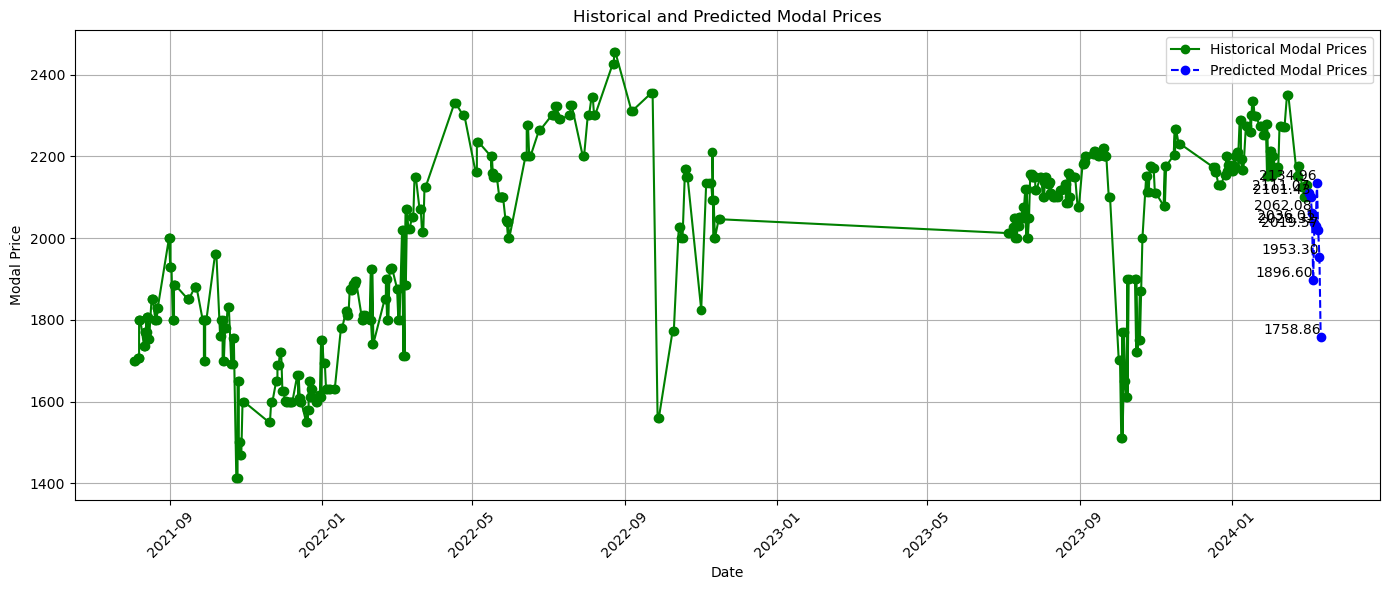

In [19]:
# Visualize the future predictions with labels
future_dates = pd.date_range(start=filtered_data['date'].max() + pd.Timedelta(days=1), periods=10, freq='D')
future_df = pd.DataFrame(future_predictions, columns=targets)
future_df['date'] = future_dates

# Plot historical values and future predictions
plt.figure(figsize=(14, 6))
plt.plot(filtered_data['date'], filtered_data['modalprice'], marker='o', linestyle='-', color='g', label='Historical Modal Prices')
plt.plot(future_df['date'], future_df['modalprice'], marker='o', linestyle='--', color='b', label='Predicted Modal Prices')

# Add labels to each predicted data point
for x, y in zip(future_df['date'], future_df['modalprice']):
    plt.text(x, y, f'{y:.2f}', ha='right', va='bottom', fontsize=10)

plt.title('Historical and Predicted Modal Prices')
plt.xlabel('Date')
plt.ylabel('Modal Price')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()  # Adjust layout to prevent overlapping labels
plt.show()

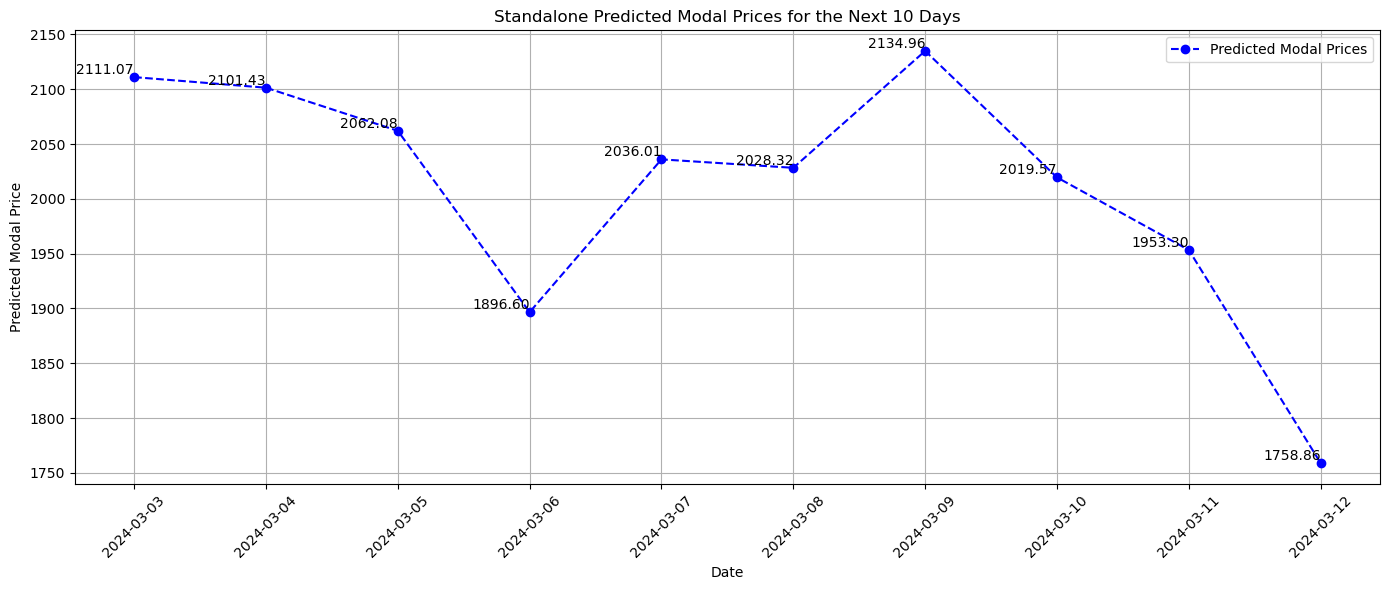

In [20]:
# Plot standalone future predictions for modal price with labels
plt.figure(figsize=(14, 6))
plt.plot(future_df['date'], future_df['modalprice'], marker='o', linestyle='--', color='b', label='Predicted Modal Prices')

# Add labels to each predicted data point
for x, y in zip(future_df['date'], future_df['modalprice']):
    plt.text(x, y, f'{y:.2f}', ha='right', va='bottom', fontsize=10)

plt.title('Standalone Predicted Modal Prices for the Next 10 Days')
plt.xlabel('Date')
plt.ylabel('Predicted Modal Price')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

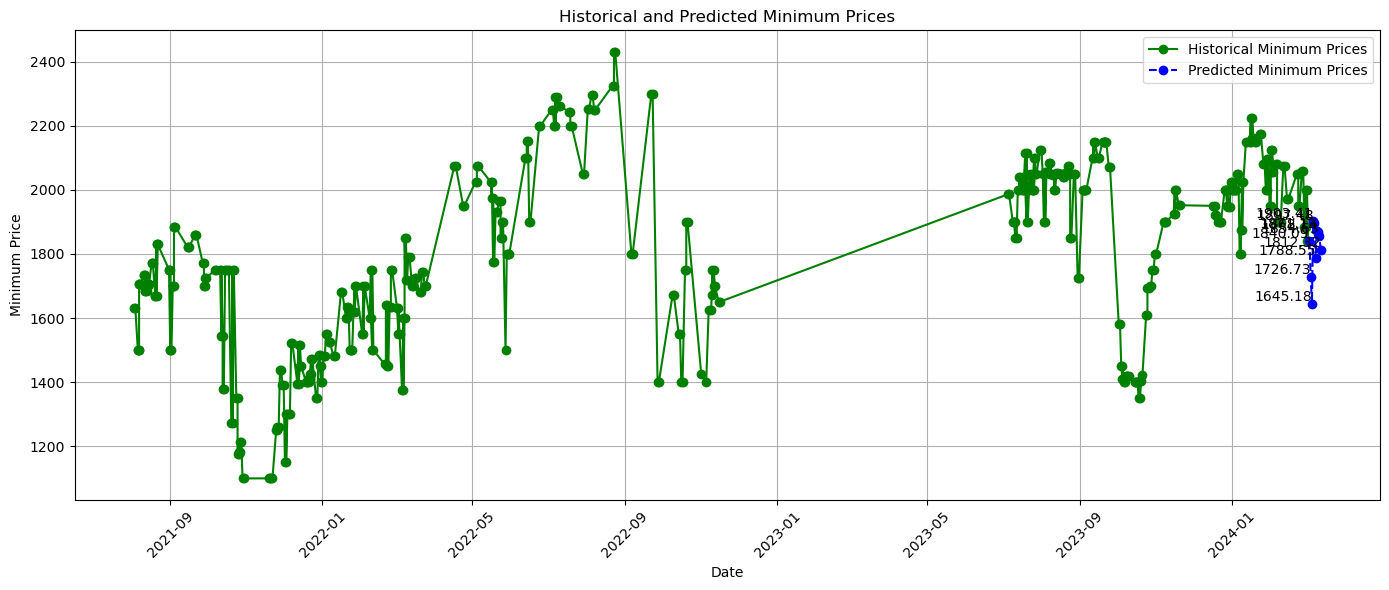

In [21]:
# Plot historical values and future predictions for minimum price
plt.figure(figsize=(14, 6))
plt.plot(filtered_data['date'], filtered_data['minimumprice'], marker='o', linestyle='-', color='g', label='Historical Minimum Prices')
plt.plot(future_df['date'], future_df['minimumprice'], marker='o', linestyle='--', color='b', label='Predicted Minimum Prices')

# Add labels to each predicted data point
for x, y in zip(future_df['date'], future_df['minimumprice']):
    plt.text(x, y, f'{y:.2f}', ha='right', va='bottom', fontsize=10)

plt.title('Historical and Predicted Minimum Prices')
plt.xlabel('Date')
plt.ylabel('Minimum Price')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()  # Adjust layout to prevent overlapping labels
plt.show()

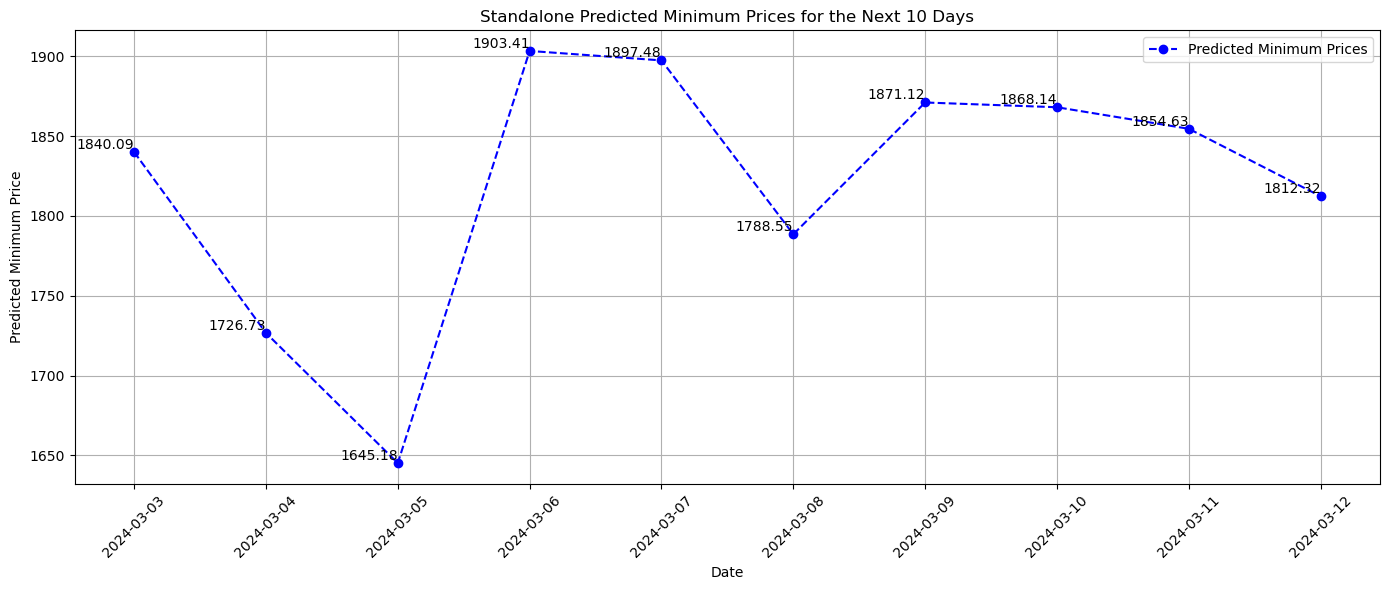

In [22]:
# Plot standalone future predictions for minimum price with labels
plt.figure(figsize=(14, 6))
plt.plot(future_df['date'], future_df['minimumprice'], marker='o', linestyle='--', color='b', label='Predicted Minimum Prices')

# Add labels to each predicted data point
for x, y in zip(future_df['date'], future_df['minimumprice']):
    plt.text(x, y, f'{y:.2f}', ha='right', va='bottom', fontsize=10)

plt.title('Standalone Predicted Minimum Prices for the Next 10 Days')
plt.xlabel('Date')
plt.ylabel('Predicted Minimum Price')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

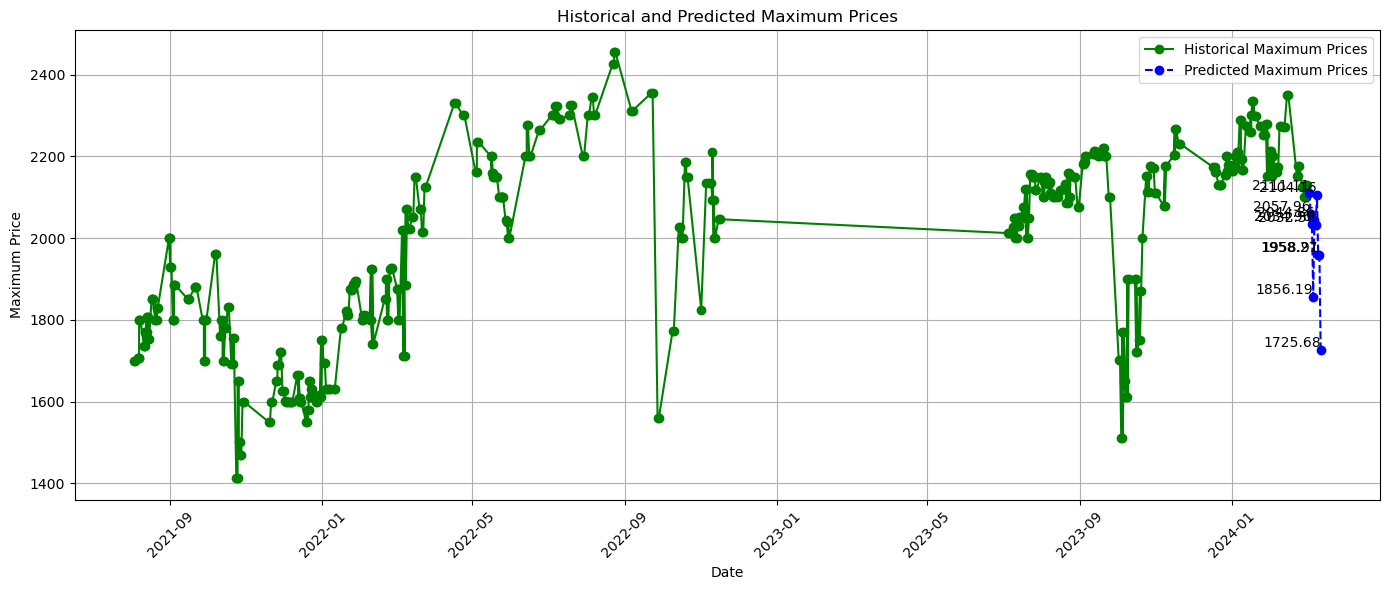

In [23]:
# Plot historical values and future predictions for maximum price
plt.figure(figsize=(14, 6))
plt.plot(filtered_data['date'], filtered_data['maximumprice'], marker='o', linestyle='-', color='g', label='Historical Maximum Prices')
plt.plot(future_df['date'], future_df['maximumprice'], marker='o', linestyle='--', color='b', label='Predicted Maximum Prices')

# Add labels to each predicted data point
for x, y in zip(future_df['date'], future_df['maximumprice']):
    plt.text(x, y, f'{y:.2f}', ha='right', va='bottom', fontsize=10)

plt.title('Historical and Predicted Maximum Prices')
plt.xlabel('Date')
plt.ylabel('Maximum Price')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()  # Adjust layout to prevent overlapping labels
plt.show()

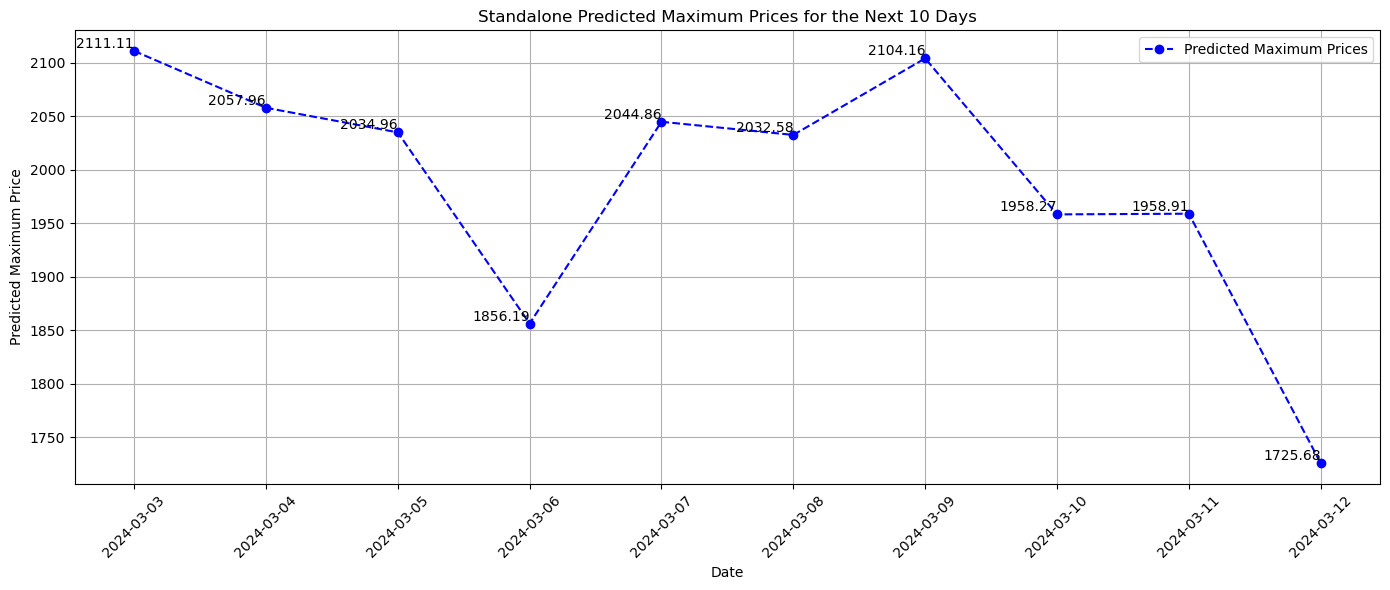

In [24]:
# Plot standalone future predictions for maximum price with labels
plt.figure(figsize=(14, 6))
plt.plot(future_df['date'], future_df['maximumprice'], marker='o', linestyle='--', color='b', label='Predicted Maximum Prices')

# Add labels to each predicted data point
for x, y in zip(future_df['date'], future_df['maximumprice']):
    plt.text(x, y, f'{y:.2f}', ha='right', va='bottom', fontsize=10)

plt.title('Standalone Predicted Maximum Prices for the Next 10 Days')
plt.xlabel('Date')
plt.ylabel('Predicted Maximum Price')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()